In [1]:
import torch
from torch import nn, optim, tensor, Tensor
from torchdiffeq import odeint, odeint_adjoint
from torchdyn.datasets import ToyDataset
import matplotlib.pyplot as plt

1. Generate the dataset - a distribution we want to transfer it into standard normal distribution.

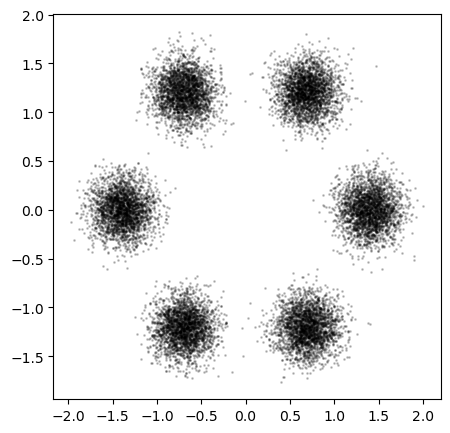

In [13]:
n_samples = 2 ** 14 # the number of samples
n_gaussians = 6 # the number of Gaussians

X, _ = ToyDataset().generate(n_samples // n_gaussians, 
                              'gaussians', 
                              n_gaussians=n_gaussians, 
                              std_gaussians=.5,
                              radius=4,dim=2)


X = (X - X.mean()) / X.std()

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.2, s=1.)


In [20]:
X.size()

torch.Size([16380, 2])

2. According to the conclusion of Zhang et. al.
    $$ \begin{cases} \partial_{t}\begin{bmatrix} \mathbf{z}(\mathbf{x},t) \\ \ell(\mathbf{x},t) \end{bmatrix} = \begin{bmatrix} \mathbf{v}(\mathbf{z}(\mathbf{x},t), t;\boldsymbol{\theta}) \\ \text{tr}(\nabla \mathbf{v}(\mathbf{z}(\mathbf{x},t), t;\boldsymbol{\theta})) \end{bmatrix} \\ \begin{bmatrix} \mathbf{z}(\mathbf{x},t) \\ \ell(\mathbf{x},t) \end{bmatrix} =  \begin{bmatrix} \mathbf{x} \\ 0 \end{bmatrix} \end{cases} $$
    where $\nabla \mathbf{v}(\mathbf{z}(\mathbf{x},t),t;\boldsymbol{\theta})$ is the Jacobian Matrix: given that the input is $\mathbf{x}_{\text{in}}$ and the output is $\mathbf{x}_{\text{out}}$. therefore, we have:
    $$
    \mathbf{x}_{\text{out}} = \mathbf{x}_{\text{in}} + \int_{0}^{t'} \mathbf{v}(\mathbf{z}(\mathbf{x},t),t;\boldsymbol{\theta}) \,dt
    $$


In [14]:
def autograd_trace(x_out, x_in):
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False ,create_graph=True)[0][:, i]
    return trJ

In [5]:
2**14

16384